# Monte Carlo Pricing of European arithmetic Asian options

<b> YouTube Tutorial </b> (Published: May 5, 2022): https://youtu.be/HjaWw7f2ulk

In this tutorial we will investigate the Monte Carlo simulation method for use in valuing financial derivatives. The mathematic notation and examples are from Les Clewlow and Chris Strickland's book Implementing Derivatives Models.

Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

$\begin{equation}\LARGE
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

Note: This is the Risk-neutral Expectation Pricing Formula in Continuous Time

In [ ]:
# Import dependencies
import time
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

## Path-Dependent Options - Asian Options

In this example we are pricing a European arithmetic Asian call option. The option pays the difference between the arithmetic average of the asset price $A_T$ and the strike price $K$ at the maturity date $T$. The arithmetic average is taken on a set of observations of the asset price $S_{T_i}$ which we assume follows a GBM at dates $t_i = 1,...,N$.

For an Asian (average price) option: $A_T = \frac{1}{N}\sum^N_{i=1}S_{t_i}$

Payoff at maturity date is : $C_T[T_1,T_2] = f(S_T) = max(0, A_T - K)$

$\begin{equation}\large
C(t,T_1, T_2) = e^{-r(T_2 - t)}\mathbb{E}_{\mathbb{Q}}[C_T[T_1,T_2] \mid F_t]
\end{equation}$

$\begin{equation}\large
C(t,T_1, T_2) = e^{-r(T_2 - t)}\mathbb{E}_{\mathbb{Q}}[(\frac{1}{T_2 - T_1} \int^{T_2}_{T_1} f(u,u)du - K)^+ \mid F_t]
\end{equation}$



## Q1 2023 Electricity Average Rate Option

In the National Electricity Market (NEM), there are 5 seperate markets for each state. We will be valuing a Q1 2023 Electricity Asian Option in the NSW market, with

- $F0 = 135.89$
- $Strike = 165.00$
- $t = 22/4/2022$
- $T_1 = 1/1/2023$
- $T_2 = 31/3/2023$
- $T_2-T_1 = 90 days$

Contract specification, average taken on 288 trading intervals each day over future contract period, Q1 90 day period. Hence we will have 25920 observations for our arithmetic average.

In [ ]:
t = datetime(2022,4,22)
T1 = datetime(2023,1,1)
T2 = datetime(2023,3,31)
Q123_days = ((T2 - T1).days+1)

# Initialise parameters
S0 = 135.89               # initial stock price
K = 165.00                # strike price
T = ((T2-t).days)/365     # time to maturity in years
r = 0.0                   # annual risk-free rate
vol = 0.5307              # volatility (%)

N = Q123_days*288         # number of time steps
M = 1000                  # number of simulations

Q123_days, N

(90, 25920)

## In Reality

Electricity Average Rate Options in Australia / NZ Energy Markets are settled against the final futures prices. As futures are settled against the <b>arithmetic average of the wholesale energy market price</b>. Therefore final futures price is the arithmetic average of wholesale electricity price.

### Reference Price for Option Exercise
In accordance with the final Settlement Price of the underlying
futures contract as determined on the Third Business Day after the
Final Trading Day.

### Method of Option Exercise
On the Third Business Day after the Final Trading Day all in-themoney options are automatically exercised into the underlying
futures contract and cash settled. Deny Automatic Exercise Requests
are not permitted. Exercise Requests for out-of-the-money options
and/or at-the-money options are not permitted.

### What that means?

These options can be priced using blackscholes until the end of the quarter.

In [ ]:
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [ ]:
print("Black Scholes Option Price: ", round(blackScholes(r, S0, K, T, vol, "c"),2))

Black Scholes Option Price:  18.08


## To demonstrate Pricing of an Average Rate Option

And to make things more interesting... let's trade OTC, a bespoke Average Rate Option over Q123 with the underlying as the futures contract.

Let's say that the average rate option prices are determined by the average of the (closing) daily futures prices across the Q123 period.  

### OTC (Bespoke) Arithmetic Average Options Price Q123 Futures Contract

## Slow Solution - Steps

In [ ]:
# slow steps - discretized every day
N = Q123_days

T_tT2 = ((T2-t).days+1)/365
T_tT1 = (T1-t).days/365
print("Start averaging from T1", round(T_tT1,2), "to T2", round(T_tT2,2))

obs_times = np.linspace(T_tT1,T_tT2,N+1)
# Include starting time, uneven time delta's
obs_times[0]=0
dt = np.diff(obs_times)
print("Number of time steps:", len(dt))

Start averaging from T1 0.7 to T2 0.94
Number of time steps: 90


In [ ]:
start_time = time.time()

nudt = np.full(shape=(N), fill_value=0.0)
volsdt = np.full(shape=(N), fill_value=0.0)

# Precompute constants
for i in range(N):
    nudt[i] = (r - 0.5*vol**2)*dt[i]
    volsdt[i] = vol*np.sqrt(dt[i])

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):

    St = S0
    At_sum = 0

    for j in range(N):
        epsilon = np.random.normal()
        St = St*np.exp( nudt[j] + volsdt[j]*epsilon )
        At_sum += St

    A = At_sum/N
    CT = max(0, A - K)

    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0_slow = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE_slow = sigma/np.sqrt(M)

time_comp_slow = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_slow,3),np.round(SE_slow,3)))
print("Computation time is: ", time_comp_slow)

Call value is $15.705 with SE +/- 1.267
Computation time is:  0.5684


# Fast Implementation - Vectorized with Numpy

In [ ]:
# fast steps - discretized every day (288 trading intervals)
N = Q123_days

obs_times = np.linspace(T_tT1,T_tT2,N+1)
# Include starting time, uneven time delta's
obs_times[0]=0
dt = np.diff(obs_times)
print("Number of time steps:", len(dt))

Number of time steps: 90


In [ ]:
start_time = time.time()

nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)

# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
AT = np.cumsum(ST, axis=0)/N
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )

CT = np.maximum(0, AT[-1] - K)
C0_fast = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_fast = sigma/np.sqrt(M)

time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,3),np.round(SE_fast,3)))
print("Computation time is: ", time_comp_fast)

Call value is $16.917 with SE +/- 1.359
Computation time is:  0.0168


## Variation Reduction Comparison

### Antithetic

In [ ]:
start_time = time.time()

nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)

# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S0*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S0*np.cumprod( np.exp(delta_St2), axis=0)
AT1 = np.cumsum(ST1, axis=0)/N
AT2 = np.cumsum(ST2, axis=0)/N
# ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )

CT = 0.5 * ( np.maximum(0, AT1[-1] - K) + np.maximum(0, AT2[-1] - K) )
C0_av = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_av)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_av = sigma/np.sqrt(M)

time_comp_av = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_av,3),np.round(SE_av,3)))
print("Computation time is: ", time_comp_av)

Call value is $15.42 with SE +/- 0.867
Computation time is:  0.0151


# Geometric Asian Option Control Variate

There is no analytical solution for an arithmetic Asian option, however there is for a geometric Asian option. This is because the geometric average is the product of lognormally distributed variables and therefore it is also lognormally distributed.

For an Geometric Asian (Geometric average price) option: $G_T = (\prod^N_{i=1}S_{t_i})^{\frac{1}{N}}$

Payoff at maturity date is : $C_T[T_1,T_2] = f(S_T) = max(0, G_T - K)$

Closed form solution: $C_{geometric \ asian} = S_0 A_j N(d_{n-j} + \sigma \sqrt{T_{2,n-j}}) - Ke^{-rT}N(d_{n-j})$

where:

$d_{n-j} = \frac{ln(\frac{S_0}{K})+(r-\frac{\sigma^2}{2})T_{1,n-j}+ln(B_j)}{\sigma \sqrt{T_{2,n-j}}}$

$A_j = B_je^{-r(T-T_{1,n-j})-\sigma^2(T_{1,n-j}-T_{2,n-j})/2}$

$T_{1,n-j} = \frac{n-j}{n}(T - \frac{(n-j-1)h}{2})$

$T_{2,n-j} = (\frac{n-j}{n})^2 T - \frac{(n-j)(n-j-1)(4n-4j+1)}{6n^2}h$

$B_j = (\prod^n_{j=1} \frac{ST-(n-j)h}{S})^{1/n}$, $B_0 = 1$


n is the number of observations to form the average, h is the observation frequency, j is the number
of observations past in the averaging period

In [ ]:
def discrete_geometric_asian(K, dt, S, vol, r, N):
    n, h, j = len(dt), dt[-1], 0
    T = np.cumsum(dt)[-1]
    T1nj = (T-(n-j-1)*h/2)*(n-j)/n
    T2nj = T*((n-j)/n)**2 - (n-j)*(n-j-1)*(4*n-4*j+1)*h/(6*n**2)
    Bj = (np.cumprod(np.array([(S*T - (n-j)*h)/S for j in range(1,n+1)]))[-1])**(1/n)
    Bj = 1 # no oberservations past
    Aj = Bj*np.exp(-r*(T-T1nj)-0.5*vol**2*(T2nj-T1nj))
    dnj = (np.log(S/K)+(r-0.5*vol**2)*T1nj + np.log(Bj))/(vol*np.sqrt(T2nj))
    C = S*Aj*norm.cdf(dnj + vol*np.sqrt(T2nj), 0, 1) - K*np.exp(-r*T)*norm.cdf(dnj)
    return C

discrete_geometric_asian(K, dt, S0, vol, r, N)

15.948956205008614

### Simulate the difference between arithmetic and geometric Asian Options

The Geometric Asian option makes a good static hedge style control variate for the arithmetic option.

Instead of using the delta of the geometric asian option as a delta hedge control variate, we instead simulate a portfolio that is long the arithmetic and short the geometric asian option. This avoids the computation of calculating the delta at each time step and simulation path.

We then just add back the Analytical price of the Geometric Asian Option back to the MC portfolio simulation.

In [ ]:
start_time = time.time()

nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)

# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
AT = np.cumsum(ST, axis=0)/N
GT = np.cumprod(ST**(1/N), axis=0)


CT = np.maximum(0, AT[-1] - K) - np.maximum(0, GT[-1] - K)

C0_cv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_cv = sigma/np.sqrt(M)

C0_cv += discrete_geometric_asian(K, dt, S0, vol, r, N)

time_comp_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,3),np.round(SE_cv,3)))
print("Computation time is: ", time_comp_cv)

Call value is $16.268 with SE +/- 0.029
Computation time is:  0.0183


### Antithetic and control Variate

In [ ]:
start_time = time.time()

nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)

# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S0*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S0*np.cumprod( np.exp(delta_St2), axis=0)
AT1 = np.cumsum(ST1, axis=0)/N
AT2 = np.cumsum(ST2, axis=0)/N
GT1 = np.cumprod(ST1**(1/N), axis=0)
GT2 = np.cumprod(ST2**(1/N), axis=0)

CT = 0.5 * ( np.maximum(0, AT1[-1] - K) - np.maximum(0, GT1[-1] - K)
            + np.maximum(0, AT2[-1] - K) - np.maximum(0, GT2[-1] - K))


C0_acv = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_acv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_acv = sigma/np.sqrt(M)

C0_acv += discrete_geometric_asian(K, dt, S0, vol, r, N)

time_comp_acv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_acv,3),np.round(SE_acv,3)))
print("Computation time is: ", time_comp_acv)

Call value is $16.31 with SE +/- 0.019
Computation time is:  0.0321


## Comparing Variance Reduction Methods

In [ ]:
C0_variates = [C0_slow, C0_fast, C0_av, C0_cv, C0_acv]
se_variates = [SE_slow, SE_fast, SE_av, SE_cv, SE_acv]
se_red = [round(SE_fast/se,2) for se in se_variates]
comp_time = [time_comp_slow, time_comp_fast, time_comp_av, time_comp_cv, time_comp_acv]
rel_time = [round(mc_time/time_comp_fast,2) for mc_time in comp_time]
data = {'Asian Call Option Value': np.round(C0_variates,3),
        'Standard Error SE': np.round(se_variates,3),
        'SE Reduction Multiple': se_red,
        'Relative Computation Time': rel_time}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index =['Slow Estimate', 'Fast Estimate', 'with antithetic variate',
'with geometric control variate', 'with antithetic and control variates'])
df

,Asian Call Option Value,Standard Error SE,SE Reduction Multiple,Relative Computation Time
Slow Estimate,15.705,1.267,1.07,33.83
Fast Estimate,16.917,1.359,1.00,1.00
with antithetic variate,15.420,0.867,1.57,0.90
with geometric control variate,16.268,0.029,46.16,1.09
with antithetic and control variates,16.310,0.019,69.90,1.91


## Visualisation

### Calculate entire paths before $T_1$

In [ ]:
T_tot = (T2-t).days/365
T_start = (T1-t).days/365
M = 50
N = (T2-t).days

# precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


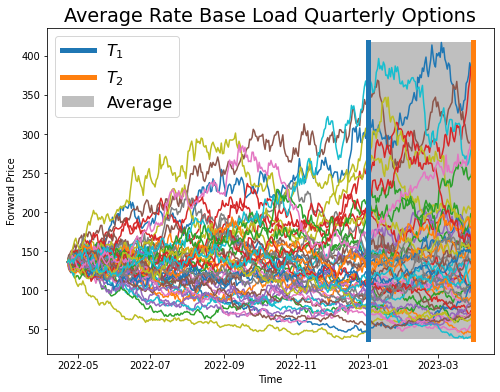

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8,6))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

tx = pd.date_range(start=t,end=T2)
ax.plot(tx,ST)
ax.plot([T1, T1],[np.amin(ST),np.amax(ST)], linewidth=5, label='$T_1$')
ax.plot([T2, T2],[np.amin(ST),np.amax(ST)], linewidth=5, label='$T_2$')

# convert to matplotlib date representation
start = mdates.date2num(T1)+1
end = mdates.date2num(T2)-1
width = end - start

ax.add_patch(Rectangle((start,np.amin(ST)),width,np.amax(ST)-np.amin(ST),
                       alpha=0.5,
                    facecolor='grey',
                    lw=4, label='Average'))
plt.xlabel('Time')
plt.ylabel('Forward Price')
plt.title('Average Rate Base Load Quarterly Options')

plt.legend()
plt.show()